<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
np.seterr(divide='ignore', over='ignore')
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import pandas as pd

## Setting up the data

In [2]:
### Load the datasets
train_dataset = datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor() ,download=True)

In [3]:
class OurOwnDataset():
    """ Our own simple dataset """
    
    def __init__(self, path, train=True):
        """ Dataset initializer """
        assert type(train), f"Unrecognized split {train}..."
        
        ### Loading data
        data_file = "training.pt" if train else "test.pt"
        data_path = os.path.join(path, data_file)
        assert os.path.exists(data_path), f"Data file {data_path} does not exist..."
        self.imgs, self.labels = torch.load(data_path)
        self.imgs = self.imgs.float()
        
        ### Converting 1d-int-labels to 10-bit-array representation
        one_hot_template = torch.eye(self.labels.max()+1)
        self.labels = one_hot_template[self.labels]
        
    def __len__(self):
        """ Getting the number of elements in the dataset """
        return len(self.labels)
        
    def __getitem__(self, idx):
        """ Sampling element 'idx' from the dataset """
        img, label = self.imgs[idx].flatten(), self.labels[idx]
        return img, label

In [4]:
data_path = "./data/MNIST/processed/"
our_train_db = OurOwnDataset(path = data_path, train=True)
our_eval_db = OurOwnDataset(path = data_path, train=False)

In [5]:
BATCH_SIZE_TRAIN = 20
BATCH_SIZE_EVAL = 10000

train_loader =  torch.utils.data.DataLoader(
        dataset=our_train_db,
        batch_size=BATCH_SIZE_TRAIN,
        shuffle=True
    )
eval_loader =  torch.utils.data.DataLoader(
        dataset=our_eval_db,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False
    )

## Thoughts on the theory

Before diving into the implementation, lets consider the involved theory. We use the following variables:
- Batch size $b$ (`BATCH_SIZE_EVAL` and `BATCH_SIZE_TRAIN`)
- $X\in\mathbb{R}^{b\times 784}\qquad=$ Input (`imgs`)
- $W_{\text{ih}}\in\mathbb{R}^{64\times 784}\quad=$ Weights between the input layer and the hidden layer (`W_i_h`)
- $H\in\mathbb{R}^{b\times 64}\qquad=$ Hidden layer activations with sigmoid activation function $\sigma_{\text{act}}$  (`sigmoid`)
- $W_{\text{ho}}\in\mathbb{R}^{10 \times 64}\quad=$ Weights between the hidden layer and the output layer (`W_h_o`)
- $O\in\mathbb{R}^{b\times 10}\qquad=$ Output layer activations with softmax probability function $f_{\text{sm}}$  (`softmax`) ($O = f_{\text{sm}}(\tilde{o})$ with $\tilde{o}\in\mathbb{R}^{b\times 10}$)
- $Y\in\mathbb{R}^{b\times 10}\qquad=$ Labels (`labels`)

### The forward pass:
- $\tilde{h}= W_{\text{ih}} X\qquad$ (with dimensions ${b\times 64}=({64\times 784})({b\times 784 \times 1})$) (`out_1` as col vec, then *squeeze()*)
- $H= \sigma_{\text{act}}\Big(\tilde{h}\Big)\qquad$ (with dimensions ${b\times 64}$) (`out_act_1`)
- $\tilde{o}= W_{\text{ho}} H\qquad$ (with dimensions ${b\times 10}=({10\times 64})({b\times 64 \times 1})$) (`out_2` as col vec, then *squeeze()*)
- $O=f_{\text{sm}}\Big(\tilde{o} \Big)\qquad$ (with dimension ${b\times 10}$) (`out_act_2`)

## Setting up the training

In [6]:
### Weight matrixes setup
hidden_size = 64

W_i_h_init = np.random.rand(hidden_size,784)-0.5
W_i_h_init = W_i_h_init - W_i_h_init.mean()
W_i_h = W_i_h_init.copy()

W_h_o_init = np.random.rand(10,hidden_size)-0.5
W_h_o_init = W_h_o_init - W_h_o_init.mean()
W_h_o = W_h_o_init.copy()

In [7]:
### Definition of the activation 
def sigmoid(t, derivative=False):
  if not derivative:
    ''' Sigmoid function'''
    return 1 / (1+np.exp(-t))
    ### We failed to eliminate: 'RuntimeWarning: overflow encountered in exp'
    ### Our cure: 'np.seterr(divide='ignore', over='ignore')'
  else: 
    return sigmoid(t) * (1- sigmoid(t))

In [8]:
def softmax(t, derivative=False, dE = None):
  if not derivative:
    # stabilize the exp a bit
    t_shift = t - np.max(t, axis=-1, keepdims=True)
    tmp = np.exp(t_shift)
    return tmp / tmp.sum(-1)[:,None]
  else:
    S = softmax(t)
    # S.shape = (BS, 10)
    # want: (BS, 10, 10) matrices with S on the diagonals
    diag_matrices = np.einsum('ij,jk->ijk', S, np.eye(S.shape[-1]))
    # want: (BS, 10, 10) covariance matrices
    cov = S[:,:,None] @ S[:,None,:]
    # put together the Jacobian
    dt = diag_matrices - cov
    return (dt @ dE[:,:,None]).squeeze(axis=-1)

In [9]:
### Learning rate 
alpha = 1e-3

### Saving the losses for every epoch for validation and training
losses_eval = []
losses_train = []

num_epochs = 150
print_every = 1

In [10]:
progress_bar = tqdm(range(num_epochs), total=num_epochs)
for epoch in progress_bar:
  losses_train_epoch = []

  ### EVALUATION
  for i, (imgs, labels) in enumerate(eval_loader):
    ### Conversion of TorchTensor to Numpy
    imgs = imgs.numpy()
    labels = labels.numpy()

    ### FORWARD PASS:
    ### 1. Layer
    out_1 =  (W_i_h @ imgs[:,:,None]).squeeze(axis=-1)
    out_act_1 = sigmoid(out_1)
    ### 2. Layer
    out_2 = (W_h_o @ out_act_1[:,:,None]).squeeze(axis=-1)
    out_act_2 = softmax(out_2)
    ### LOSS COMPUTATION:
    E = labels - out_act_2
    MSE = np.power(E, 2).mean(-1)

  ### Save & print evaluation error
  losses_eval.append(MSE.mean())

  ### TRAINING
  for i, (imgs, labels) in enumerate(train_loader):
    ### Conversion of TorchTensor to Numpy
    imgs = imgs.numpy()
    labels = labels.numpy()

    ### FORWARD PASS:                                                           
    ### 1. Layer
    out_1 =  (W_i_h @ imgs[:,:,None]).squeeze(axis=-1)
    out_act_1 = sigmoid(out_1)
    ### 2. Layer
    out_2 = (W_h_o @ out_act_1[:,:,None]).squeeze(axis=-1)
    out_act_2 = softmax(out_2)
    ### LOSS COMPUTATION:
    E = labels - out_act_2
    MSE = np.power(E, 2).mean(-1)
    losses_train_epoch.append(MSE.mean())

    ### BACKWARD PASS:  
    delta_o = softmax(out_2, derivative=True, dE=2*E)
    o_err = (W_h_o.T @ delta_o[:,:,None]).squeeze(axis=-1)
    delta_i = o_err * sigmoid(out_1, derivative=True)


    W_h_o_grads = delta_o[:,:,None] @ out_act_1[:,None]
    W_h_o = W_h_o + alpha * W_h_o_grads.sum(0)
    W_i_h_grads = delta_i[:,:,None] @ imgs[:,None]
    W_i_h = W_i_h + alpha * W_i_h_grads.sum(0)  

  ### Save & print training error
  mean_loss_train_epoch = np.array(losses_train_epoch).mean()
  losses_train.append(mean_loss_train_epoch)
  if(epoch % print_every == 0 or epoch == num_epochs-1):
        progress_bar.set_description(f"Epoch: {epoch+1} | train: {losses_train[-1]:.5f} | valid: {losses_eval[-1]:.5f}. ")

---
### Plotting the results: MSE-loss over time for training and validation

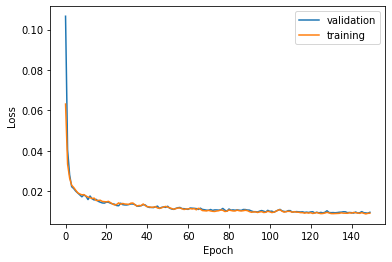

In [11]:
plt.plot(np.array(losses_eval),label='validation')
plt.plot(np.array(losses_train),label='training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
def evaluate(image):
    ''' Letting the trained net evaluate a batch of given images
        The function returns a batch of integers in {0,...,9},
        representing the learned classification of the image by
        the net.
    '''
    out_1 =  (W_i_h @ image[:,:,None]).squeeze(axis=-1)
    out_act_1 = sigmoid(out_1)
    out_2 = (W_h_o @ out_act_1[:,:,None]).squeeze(axis=-1)
    out_act_2 = softmax(out_2)  
    return np.argmax(out_act_2.reshape(-1,10),axis=-1)

### Showing the results: Learned classification for a random sample of images

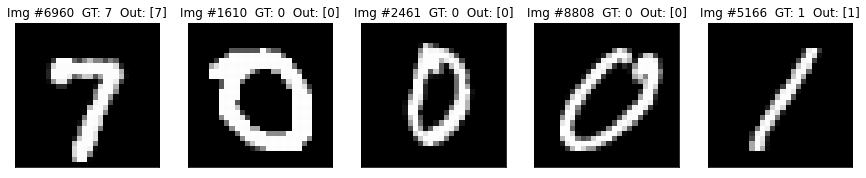

In [13]:
fig, ax = plt.subplots(1,5)
fig.set_size_inches(15, 3)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

### Fetching 'size' random identifiers for the examplary sample
ids = np.random.randint(low=0, high=len(our_eval_db), size=5)

for iter, id in enumerate(ids):
    ### Fetching the current image and its label
    img = our_eval_db[id][0].numpy().reshape(1,-1)
    true_label = np.argmax(our_eval_db[id][1])
    ### Letting the trained net evaluate the image
    predicted_label = evaluate(img)

    ax[iter].imshow(img.reshape(28,28), cmap='gray')
    ax[iter].set_title(f"Img #{id}  GT: {true_label}  Out: {predicted_label}")
    
plt.show()

### Quantifying the results: Print accuracy and confusion matrix.

In [14]:
images, labels = our_eval_db[:]
images = images.numpy().reshape((-1,784))
labels = labels.numpy().argmax(-1)
predicted_labels = evaluate(images)

n_correct = (predicted_labels == labels).sum()
accuracy = n_correct / len(labels) * 100
print(f'Classification accuracy: {round(accuracy, 2)}%')
print('Confusion Matrix:')
df_confusion = pd.crosstab(labels, predicted_labels, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion.head(10)

Classification accuracy: 94.24%
Confusion Matrix:


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,956,1,4,0,1,5,9,2,2,0,980
1,0,1110,3,2,1,0,4,2,12,1,1135
2,10,1,969,8,4,4,11,12,11,2,1032
3,2,2,18,932,0,28,0,11,10,7,1010
4,0,1,4,1,924,0,12,3,4,33,982
5,6,6,2,22,3,822,10,3,12,6,892
6,5,2,4,1,8,13,919,2,4,0,958
7,1,6,16,9,4,2,0,975,3,12,1028
8,8,2,8,21,7,7,7,8,897,9,974
